# Reddit Flair Classifier

## Key points of Notebook
- Pre-processing   
    We simply filled all nan value with `" "` in Body and combined_comments. And converted all titled to string using lambda funtion. Most of dataset is pre-processed in `EDA Notebook`.
- Feature Extraction from Dataset.  
    We have used `TF-IDF(term frequency-inverse document frequency)` and have taken two approach for collection of documents. [Ref](https://www.geeksforgeeks.org/feature-extraction-techniques-nlp/)  
    - Simple stopwatch provided by nlkt library as Collection of documents.
    - Creating Collection of document using given dataset.
- Trainig Models on diffrent data distribution.  
    - We have used 4 classification algorithm.  
        - [Naive Bayes classifier for multinomial models](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
        - [Linear classifiers with SGD training.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
        - [Logistic Regression (aka logit, MaxEnt) classifier.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
        - [A random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  
    - We have used four diffrent approach for Input Features for Flair Classification.  
        - Input Data - `Title`, Label - `Flair`
        - Input Data - `Body`, Label - `Flair`
        - Input Data - `Comments`, Label - `Flair`
        - Input Data - `Title + Body + Comments`, Label - `Flair`

In [311]:
# Importing Libraries
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

import nltk
from nltk import word_tokenize
from nltk.util import ngrams  
import collections
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

sns.set(style="darkgrid")

# Pre-processing
## Extracting data from saved .csv file

In [312]:
df = pd.read_csv('cleaned_d.csv')

In [313]:
df.head()

,Unnamed: 0,Flair,Title,Created_at,Score,Url_address,Body,Author,num_comments,combined_comments
0,0,AskIndia,attractive men type attention receive others l...,2019-08-14 00:59:47,20,https://www.reddit.com/r/india/comments/cprtaa...,xposted r askmen posted india socially cultura...,sleepless_indian,21,mom says im good looking answer yeah shes one ...
1,1,AskIndia,askindia brothers bank account hacked morning,2019-09-28 20:17:34,37,https://www.reddit.com/r/india/comments/dacmel...,brother received bunch sms morning around 3am ...,prtthrowaway,64,copy paste one previous commentsaccording rbis...
2,2,AskIndia,askindia song,2019-08-11 08:46:23,5,https://www.reddit.com/r/india/comments/comakt...,often think home particular hindi pop song pla...,lockworm,6,hamari adhoori kahani aka bheegi bheegi si hai...
3,3,AskIndia,askindia serious worth attempting immigration ...,2019-06-24 18:41:18,56,https://www.reddit.com/r/india/comments/c4ilk5...,title understand based armchair research motiv...,aashish2137,115,nri fairly neutral opinion heresome cons arent...
4,4,AskIndia,askindia cheap reliable long lasting laptop mo...,2019-11-01 01:27:04,21,https://www.reddit.com/r/india/comments/dpmgmj...,wont play games edit videosi use laptop web su...,advice2019-,25,way future proof anything best bet machine las...


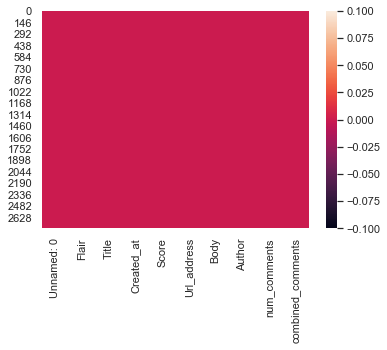

In [314]:
df.Body.fillna(' ', inplace=True)
df.combined_comments.fillna(' ', inplace=True)
df['Title'] = df['Title'].apply(lambda x : str(x))
sns.heatmap(df.isnull())

## Function below which takes `X_train, X_test, y_train, y_test` as input, train this data and return a DataFrame of accuracy for each algorithm we discuss above.

In [315]:
def prediction(X_train, X_test, y_train, y_test):
    prediction_accuracy = {}
    
    # Multinomial Naive Bayes Classifier
    _naive_bayes = MultinomialNB()
    _naive_bayes.fit(X_train, y_train)
    _naive_bayes_prediction = _naive_bayes.predict(X_test)
    prediction_accuracy['Multinomial Naive Bayes'] = round(accuracy_score(_naive_bayes_prediction, y_test)*100, 2)
    
    # Logistic Regression Classifier
    _LogisticRegression = LogisticRegression(multi_class='ovr', solver='liblinear')
    _LogisticRegression.fit(X_train, y_train)
    _LogisticRegression_prediction = _LogisticRegression.predict(X_test)
    prediction_accuracy['Logistic Regression'] = round(accuracy_score(_LogisticRegression_prediction, y_test)*100, 2)
    
    # Random Forest Classifier
    _RandomForestClassifier = RandomForestClassifier(n_estimators = 1000, min_samples_split = 15, random_state = 42)
    _RandomForestClassifier.fit(X_train, y_train)
    _RandomForestClassifier_prediction = _RandomForestClassifier.predict(X_test)
    prediction_accuracy['Random Forest'] = round(accuracy_score(_RandomForestClassifier_prediction, y_test)*100, 2)
    
    # Support Vector Machine
    _SVC = SVC(C = 0.4, kernel = 'linear', gamma='auto')
    _SVC.fit(X_train, y_train)
    _SVC_prediction = _SVC.predict(X_test)
    prediction_accuracy['Support Vector Machine'] = round(accuracy_score(_SVC_prediction, y_test)*100, 2)
    
    #accuracy DataFram
    prediction_accuracy_df = pd.DataFrame(prediction_accuracy.items(), columns=['Classifier', 'Accuracy'], index=None)
    return prediction_accuracy_df

## This is the frist approach we used for feature extraction, This function takes `Input data and Label` and return transformed data.

In [316]:
def simple_stopwatch_approach(X, y):
    y = df.Flair
    # Label encoding the classes
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
    # Creating the vectorizer
    tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=20, stop_words= STOPWORDS )
    X_train = tfidf.fit_transform(X_train).toarray()
    X_test = tfidf.transform(X_test).toarray()
    return X_train, X_test, y_train, y_test

## This is the second approach we used for feature extraction, This function takes Input data and Label and return transformed data.  
- [Refrence 1](https://www.kaggle.com/rtatman/tutorial-getting-n-grams)
- [Refrence 2](https://stackabuse.com/python-for-nlp-developing-an-automatic-text-filler-using-n-grams/)

In [317]:
flairs = ['AMA', 'AskIndia', 'Business/Finance', 'Coronavirus', 'Food', 'Non-Political', 'Photography', 'Policy/Economy', 'Politics', 'Scheduled', 'Science/Technology', 'Sports']

# Taking Title, body and comments to create custom vocablary
df['content'] = df.Title +' '+ df.Body +' '+ df.combined_comments 
top1 = 140
top2 = 80
custom_vocab = []

for flair in flairs:
    all_text = ' '.join(str(word) for word in df.content[df.Flair == flair].values) 
    tokens = word_tokenize(all_text)

    unigrams = ngrams(tokens, 1)
    unigrams = collections.Counter(unigrams)
    unigrams = unigrams.most_common(top1)
    for i in range(top1):
        custom_vocab.append(unigrams[i][0][0])

    bigrams = ngrams(tokens, 3)
    bigrams = collections.Counter(bigrams)
    bigrams = bigrams.most_common(top2)
    for i in range(top2):
        custom_vocab.append(bigrams[i][0][0]+' '+bigrams[i][0][1])

custom_vocab = list(set(custom_vocab))
custom_vocab = [word for word in custom_vocab if word not in STOPWORDS]

# Creating TF-IDF Vectorizer using custom custom_vocab

tfidf = TfidfVectorizer(vocabulary = custom_vocab)

# Saving in pickel file to use it in WebApp
with open("ngrams_vectorizer.pkl", 'wb') as file:  
    pickle.dump(tfidf, file)
    
def custom_approach(X, y):
    y = df.Flair
    # Label encoding the classes 
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

    X_train = tfidf.fit_transform(X_train).toarray()

    X_test = tfidf.transform(X_test).toarray()
    return X_train, X_test, y_train, y_test


### Utility function to plot model Accuracy.

In [318]:
def accuracy_plot(a, b, title):
    fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(14,3))
    fig.suptitle(title)
    ax1.barh(np.arange(len(list(a.Classifier))), list(a.Accuracy), color='#26a69a', height=0.9)
    for i in list(a.Accuracy):
        ax1.text(i + 1, list(a.Accuracy).index(i) , i,fontsize=12)
    ax1.set_title( "NLKT stopwatch vocabulary Approach.")
    ax1.set_yticks(np.arange(len(list(a.Classifier))))
    ax1.set_yticklabels(list(a.Classifier))
    ax1.set_xlim((0, 100))
    ax1.set_xlabel("Accuracy %", fontsize=15)
    ax1.grid(False)
    ax1.set_ylabel("Models", fontsize=15)
    
    ax2.set_title( "Custom vocabulary Approach.")
    ax2.barh(np.arange(len(list(b.Classifier))), list(b.Accuracy), color='#26a69a', height=0.9)
    for j in list(b.Accuracy):
        ax2.text(j + 1, list(b.Accuracy).index(j) , j,fontsize=12)
    ax2.set_xlim((0, 100))
    ax2.set_yticks([])
    ax2.set_xlabel("Accuracy %", fontsize=15)
    ax2.grid(False)

## Taking Title as Input Feature.  
- NLKT stopwatch vocabulary Approach  
- Custom vocabulary Approach

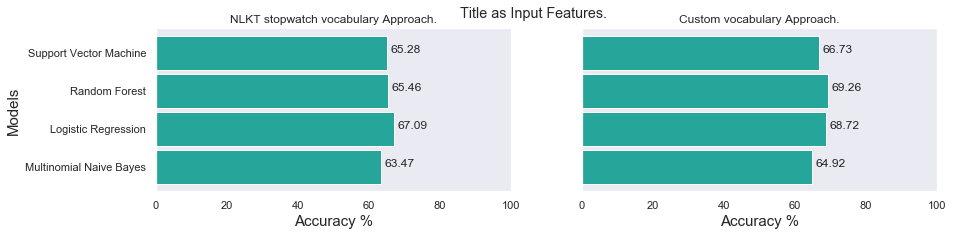

In [307]:
# NLKT stopwatch vocabulary Approach.
X_train, X_test, y_train, y_test = simple_stopwatch_approach(df.Title , df.Flair)
p_df = prediction(X_train, X_test, y_train, y_test) # Returns DataFrame

# Custom vocabulary Approach.
X_train, X_test, y_train, y_test = custom_approach(df.Title, df.Flair)
pp_df = prediction(X_train, X_test, y_train, y_test) # Returns DataFrame

# Calling accuracy_plot function to get plots
accuracy_plot(p_df, pp_df, "Title as Input Feature.\n")

## Taking Body as Input Feature.  
- NLKT stopwatch vocabulary Approach  
- Custom vocabulary Approach

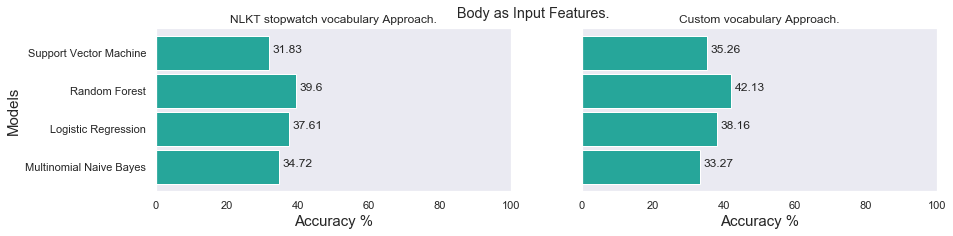

In [308]:
# NLKT stopwatch vocabulary Approach.
X_train, X_test, y_train, y_test = simple_stopwatch_approach(df.Body , df.Flair)
p_df = prediction(X_train, X_test, y_train, y_test) # Returns DataFrame

# Custom vocabulary Approach.
X_train, X_test, y_train, y_test = custom_approach(df.Body, df.Flair)
pp_df = prediction(X_train, X_test, y_train, y_test) # Returns DataFrame

# Calling accuracy_plot function to get plots
accuracy_plot(p_df, pp_df, "Body as Input Feature.\n")

## Taking Combined Comments as Input Feature.  
- NLKT stopwatch vocabulary Approach  
- Custom vocabulary Approach

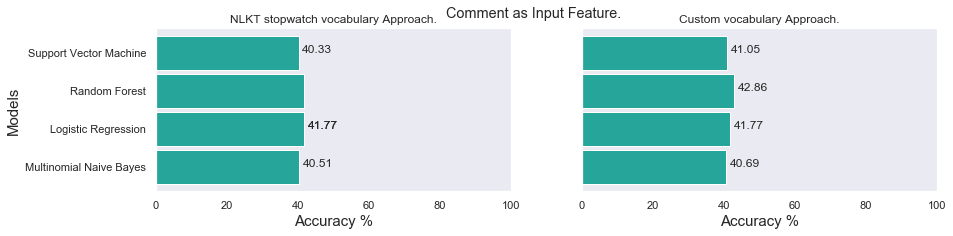

In [319]:
# NLKT stopwatch vocabulary Approach.
X_train, X_test, y_train, y_test = simple_stopwatch_approach(df.combined_comments , df.Flair)
p_df = prediction(X_train, X_test, y_train, y_test) # Returns DataFrame

# Custom vocabulary Approach.
X_train, X_test, y_train, y_test = custom_approach(df.combined_comments, df.Flair)
pp_df = prediction(X_train, X_test, y_train, y_test) # Returns DataFrame

# Calling accuracy_plot function to get plots
accuracy_plot(p_df, pp_df, "Comment as Input Feature.\n")

## Taking Taking title, body, comment combined as Input Features.  
- NLKT stopwatch vocabulary Approach  
- Custom vocabulary Approach

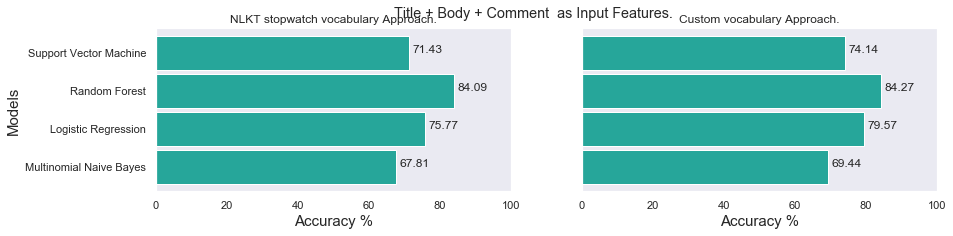

In [310]:
# NLKT stopwatch vocabulary Approach.
X_train, X_test, y_train, y_test = simple_stopwatch_approach(df.Title +' '+ df.Body +' '+ df.combined_comments , df.Flair)
p_df = prediction(X_train, X_test, y_train, y_test) # Returns DataFrame

# Custom vocabulary Approach.
X_train, X_test, y_train, y_test = custom_approach(df.Title +' '+ df.Body +' '+ df.combined_comments, df.Flair)
pp_df = prediction(X_train, X_test, y_train, y_test) # Returns DataFrame

# Calling accuracy_plot function to get plots
accuracy_plot(p_df, pp_df, "Title + Body + Comment  as Input Features.\n")

## From all the above Classification `RandomForestClassifier` with `title + body + comment_combined` as input features shows higest Accuracy.

In [228]:
X_train, X_test, y_train, y_test = custom_approach(df.Title +' '+ df.Body +' '+ df.combined_comments, df.Flair)
_RandomForestClassifier = RandomForestClassifier(n_estimators = 1000, min_samples_split = 15, random_state = 42)
_RandomForestClassifier.fit(X_train, y_train)
_RandomForestClassifier_prediction = _RandomForestClassifier.predict(X_test)
print("Accuracy => ", round(accuracy_score(_RandomForestClassifier_prediction, y_test)*100, 2))
print("\nRandom Forest Classifier results: \n")
print(classification_report(y_test, _RandomForestClassifier_prediction, target_names = list(encoder.classes_)))

Accuracy =>  84.27

Random Forest Classifier results: 

                    precision    recall  f1-score   support

               AMA       0.92      0.97      0.95        36
          AskIndia       0.87      0.89      0.88        46
  Business/Finance       0.90      0.74      0.81        47
       Coronavirus       0.81      0.90      0.85        49
              Food       0.89      0.84      0.87        50
     Non-Political       0.93      0.85      0.89        48
       Photography       0.90      0.98      0.94        48
    Policy/Economy       0.62      0.79      0.69        43
          Politics       0.72      0.69      0.71        52
         Scheduled       0.90      0.80      0.84        44
Science/Technology       0.87      0.83      0.85        48
            Sports       0.86      0.86      0.86        42

          accuracy                           0.84       553
         macro avg       0.85      0.85      0.85       553
      weighted avg       0.85      0.84   

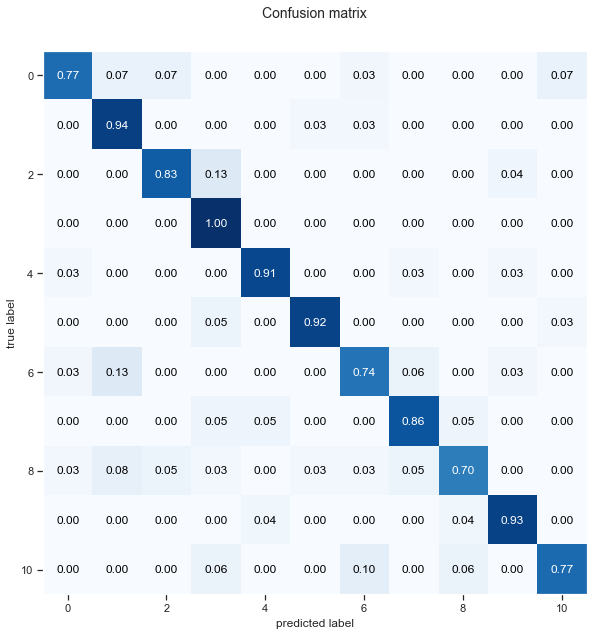

In [166]:
fig, ax = plot_confusion_matrix(conf_mat = confusion_matrix(y_test, y_pred),
                                show_absolute = False,
                                show_normed = True,
                                figsize = (10,10))
plt.title("Confusion matrix", fontsize=14)
plt.show()

## Finally saving the best model as pickel file to use in WebApp

In [229]:
import pickle
with open("model.pkl", 'wb') as file:  
    pickle.dump(_RandomForestClassifier, file)